In [5]:
# Import the necessary modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import joblib

import re
import urllib.request
from bs4 import BeautifulSoup
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from langdetect import detect_langs


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from gensim.models import Word2Vec
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

## Data Preparation

In [6]:
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

In [7]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', names=DATASET_COLUMNS, encoding=DATASET_ENCODING)

In [4]:
df.head()

sentiment         ids                          date      flag  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....

In [8]:
df = df[['sentiment', 'text']]

In [6]:
df.head()

sentiment                                               text
0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          0  is upset that he can't update his Facebook by ...
2          0  @Kenichan I dived many times for the ball. Man...
3          0    my whole body feels itchy and like its on fire 
4          0  @nationwideclass no, it's not behaving at all....

In [7]:
df.describe(include='all')

sentiment                       text
count   1.600000e+06                    1600000
unique           NaN                    1581466
top              NaN  isPlayer Has Died! Sorry 
freq             NaN                        210
mean    2.000000e+00                        NaN
std     2.000001e+00                        NaN
min     0.000000e+00                        NaN
25%     0.000000e+00                        NaN
50%     2.000000e+00                        NaN
75%     4.000000e+00                        NaN
max     4.000000e+00                        NaN

In [9]:
df_duplicates = df[df.duplicated(subset='text', keep='first')]

In [7]:
df_duplicates

sentiment                                               text
1940             0   and so the editing of 3000 wedding shots begins 
2149             0  im lonely  keep me company! 22 female, california
3743             0  I'm not liking that new iTunes Pricing at all....
3746             0  cant eat, drink or breath properly thanks to t...
4163             0                                        has a cold 
...            ...                                                ...
1599501          4                           getting used to twitter 
1599531          4  @KhloeKardashian Definitely my Mom. And Angeli...
1599678          4                                       goodmorning 
1599768          4                            Good morning everyone. 
1599931          4  Had an injection today. Not fun  the rrst of t...

[18534 rows x 2 columns]

In [10]:
df.drop_duplicates(subset='text', keep='first', inplace = True, ignore_index = True)

In [9]:
df.describe(include='all')

sentiment                                               text
count   1.581466e+06                                            1581466
unique           NaN                                            1581466
top              NaN  im ready for a bf. srsly. anyway...new belgium...
freq             NaN                                                  1
mean    2.001386e+00                                                NaN
std     2.000000e+00                                                NaN
min     0.000000e+00                                                NaN
25%     0.000000e+00                                                NaN
50%     4.000000e+00                                                NaN
75%     4.000000e+00                                                NaN
max     4.000000e+00                                                NaN

In [10]:
df.head()

sentiment                                               text
0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          0  is upset that he can't update his Facebook by ...
2          0  @Kenichan I dived many times for the ball. Man...
3          0    my whole body feels itchy and like its on fire 
4          0  @nationwideclass no, it's not behaving at all....

In [11]:
# Replacing the values to ease understanding.
df['sentiment'] = df['sentiment'].replace(4,1)

In [12]:
df.sentiment.value_counts()/len(df)*100

1    50.034651
0    49.965349
Name: sentiment, dtype: float64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1581466 entries, 0 to 1581465
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1581466 non-null  int64 
 1   text       1581466 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.1+ MB


In [13]:
df.isnull().sum()

sentiment    0
text         0
dtype: int64

In [14]:
space = [index for index,text in enumerate(df.text) if text =='']
space

[]

In [15]:
df = df.sample(frac = 0.2, replace=False, random_state=42)

In [16]:
df.describe(include='all')

sentiment                                               text
count   316293.000000                                             316293
unique            NaN                                             316293
top               NaN  school for me will be finished when I read 2 b...
freq              NaN                                                  1
mean         0.501908                                                NaN
std          0.499997                                                NaN
min          0.000000                                                NaN
25%          0.000000                                                NaN
50%          1.000000                                                NaN
75%          1.000000                                                NaN
max          1.000000                                                NaN

In [17]:
df.sentiment.value_counts()/len(df)*100

1    50.190804
0    49.809196
Name: sentiment, dtype: float64

In [18]:
df.reset_index(inplace=True, drop=True)

In [19]:
df

sentiment                                               text
0               1  @hlooman Hans I'm an open book you can ask me ...
1               1               wuaaah we have strawberries at home 
2               1  @JamesSmithComic Very cool.  And to quote TBS....
3               1                        #iremember the last sunday 
4               1         @microilist oh thanks, thats good to know 
...           ...                                                ...
316288          1  @allthatglitrs21 you mum sounds so humble ! wh...
316289          1  @DeannaKicksAss mahal la, watch both. hehe! ya...
316290          0  Our twitter has a background!  But it won't le...
316291          0         nintendo = fail .....not impressed at all 
316292          0  I has a bright red umbrella!  They didn't have...

[316293 rows x 2 columns]

In [20]:
list_car = [len(row) for row in df.text]
index_outlier = [index  for index, len_row in enumerate(list_car) if len_row > 160]
index_outlier

[7724,
 8550,
 8636,
 11441,
 16680,
 18706,
 23672,
 23804,
 29292,
 32105,
 33425,
 35156,
 35715,
 38192,
 58262,
 58396,
 59952,
 63697,
 64875,
 66773,
 70231,
 70417,
 76577,
 77609,
 78948,
 79923,
 79974,
 80154,
 81014,
 84517,
 90312,
 91018,
 92900,
 95459,
 98613,
 102230,
 107702,
 109628,
 111158,
 118737,
 124242,
 127085,
 138607,
 139700,
 143630,
 143916,
 143923,
 145257,
 145857,
 149664,
 150204,
 154762,
 159141,
 159644,
 160901,
 161217,
 165297,
 165423,
 177827,
 180257,
 181315,
 181686,
 182246,
 193264,
 194666,
 195447,
 203432,
 207377,
 207996,
 209766,
 222218,
 228737,
 229844,
 232452,
 237617,
 238921,
 240160,
 249472,
 250527,
 262361,
 267694,
 273277,
 274523,
 275854,
 276932,
 282633,
 284432,
 290809,
 290945,
 296688,
 297918,
 302786,
 303665,
 308529,
 315987]

In [21]:
len(index_outlier)

95

In [22]:
df.iloc[index_outlier].values

array([[0,
        '[DELETE FROM mb WHERE id&gt;120&amp;&amp;id&lt;140] is NOT the same as [DELETE FROM mb WHERE id&gt;120&amp;id&lt;140]. former deletes 20 entries. the latter? 140 '],
       [1,
        "@MGiraudOfficial Oh and make sure you do &quot;Who's Lovin You&quot; and &quot;Let's Get It On&quot;  Maybe sing &quot;My Love&quot; and/or &quot;Cry Me A River&quot; by JT &lt;3"],
       [1,
        'Look I was a Raver back in the Day and Still Am, but I Listen to Everything, from &quot;Sade&quot; &amp; &quot;Chaka Khan&quot; to &quot;Rage Against the Machine&quot;!  '],
       [1,
        "Headphones on, #Cheaptrick &quot;The Flame&quot; awesome song, ALMOST as good as Joe Walsh &quot;Life's Been Good 2 Me&quot; THAT is a &quot;get high to&quot; song "],
       [1,
        "&quot;&quot;I'm really glad you're in my life.&quot; :: &quot;really? how come?&quot; :: &quot;because you're awesome and you don't judge me.&quot; :: take notes friends.  "],
       [1,
        '@woofer_kyyiv,

In [23]:
languages = []

# Loop over the rows of the dataset and append  
for row in range(len(index_outlier)):
    languages.append(detect_langs(df.text[row]))

In [24]:
languages

[[en:0.9999984564747482],
 [en:0.7142841032544708, af:0.28571414313327553],
 [en:0.9999989161596415],
 [en:0.9999961145508068],
 [en:0.9999977802342863],
 [en:0.9999956370350587],
 [en:0.9999959549306141],
 [en:0.9999948323214259],
 [en:0.9999977274223687],
 [en:0.7142842476273336, nl:0.14285757035352165, so:0.14285710709312682],
 [en:0.9999967963872989],
 [en:0.9999974907378438],
 [en:0.9999970367433908],
 [en:0.9999962893712927],
 [en:0.9999976068280901],
 [en:0.999997779726052],
 [en:0.9999956497641195],
 [en:0.9999973548338521],
 [en:0.9999970072779927],
 [en:0.9999965416562283],
 [en:0.8571410852357113, so:0.14285767391271303],
 [en:0.9999964896142689],
 [en:0.999996961428446],
 [da:0.857137402139508, en:0.14285780246798274],
 [en:0.999996764692796],
 [en:0.9999962059371839],
 [en:0.9999961668711959],
 [en:0.9999989641502737],
 [en:0.9999977255744215],
 [en:0.9999983512146491],
 [en:0.9999976383912235],
 [en:0.857139514054157, fr:0.14286007694340658],
 [en:0.9999951369018066],
 [e

In [25]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [26]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer
    #wordLemm = WordNetLemmatizer()
    
    # Regex patterns
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = r"[^a-zA-Z0-9]+"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
       
        
        processedText.append(tweet)
        
    return processedText

In [27]:
import time
t = time.time()
processedtext = preprocess(df.text.tolist())
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 12 seconds


In [31]:
df["filtered_text"] = processedtext 

In [32]:
df

sentiment                                               text  \
0               1  @hlooman Hans I'm an open book you can ask me ...   
1               1               wuaaah we have strawberries at home    
2               1  @JamesSmithComic Very cool.  And to quote TBS....   
3               1                        #iremember the last sunday    
4               1         @microilist oh thanks, thats good to know    
...           ...                                                ...   
316288          1  @allthatglitrs21 you mum sounds so humble ! wh...   
316289          1  @DeannaKicksAss mahal la, watch both. hehe! ya...   
316290          0  Our twitter has a background!  But it won't le...   
316291          0         nintendo = fail .....not impressed at all    
316292          0  I has a bright red umbrella!  They didn't have...   

                                            filtered_text  
0        USER hans i m an open book you can ask me any...  
1                     wuaah we have strawberries at home   
2        USER very cool and to quote tbs quot now that...  
3                              iremember the last sunday   
4                      USER oh thanks thats good to know   
...                                                   ...  
316288   USER you mum sounds so humble what a sweet th...  
316289   USER mahal la watch both hehe ya man jem is d...  
316290  our twitter has a background but it won t let ...  
316291                nintendo fail not impressed at all   
316292  i has a bright red umbrella they didn t have a...  

[316293 rows x 3 columns]

In [33]:
df.describe(include='all')

sentiment                                               text  \
count   316293.000000                                             316293   
unique            NaN                                             316293   
top               NaN  school for me will be finished when I read 2 b...   
freq              NaN                                                  1   
mean         0.501908                                                NaN   
std          0.499997                                                NaN   
min          0.000000                                                NaN   
25%          0.000000                                                NaN   
50%          1.000000                                                NaN   
75%          1.000000                                                NaN   
max          1.000000                                                NaN   

       filtered_text  
count         316293  
unique        309088  
top            USER   
freq             620  
mean             NaN  
std              NaN  
min              NaN  
25%              NaN  
50%              NaN  
75%              NaN  
max              NaN

In [34]:
len(set(df.filtered_text))

309088

### Language detection of Tweets

In [35]:
df.iloc[0, 1]

"@hlooman Hans I'm an open book you can ask me anything you want, hit up the blog and ask away, I can give you more in depth answer there "

In [36]:
df.iloc[0, 2]

' USER hans i m an open book you can ask me anything you want hit up the blog and ask away i can give you more in depth answer there '

In [37]:
detect_langs(df.iloc[0, 1])

[en:0.9999962010445058]

In [38]:
detect_langs(df.iloc[0, 2])

[en:0.9999962177321224]

In [39]:
list_car_pre = [len(row) for row in df.filtered_text]
index_outlier_pre = [index  for index, len_row in enumerate(list_car_pre) if len_row > 140]
index_outlier_pre

[1219,
 2092,
 2432,
 4250,
 4470,
 5830,
 5964,
 6474,
 7478,
 7724,
 7907,
 8550,
 8561,
 8631,
 8636,
 10025,
 10538,
 10939,
 11215,
 11441,
 12114,
 12169,
 12355,
 12746,
 13002,
 13799,
 13801,
 14085,
 15290,
 15367,
 16022,
 16324,
 16680,
 17808,
 18021,
 20276,
 22116,
 23507,
 23804,
 24222,
 26128,
 27954,
 28387,
 28696,
 30324,
 31102,
 31660,
 32692,
 32824,
 33994,
 34285,
 35715,
 36199,
 38192,
 39965,
 42324,
 42548,
 42671,
 43367,
 44058,
 45268,
 45885,
 46174,
 47462,
 48135,
 49057,
 50047,
 51235,
 51909,
 51919,
 53663,
 54537,
 54570,
 56482,
 56667,
 57694,
 58396,
 58779,
 58848,
 59952,
 60367,
 60479,
 61530,
 63057,
 63771,
 64862,
 64875,
 65049,
 65469,
 66522,
 66559,
 66773,
 67578,
 68277,
 72555,
 75606,
 76263,
 76359,
 76577,
 76599,
 77297,
 77609,
 77884,
 79314,
 79708,
 79974,
 81014,
 81107,
 81919,
 82356,
 83219,
 84077,
 84413,
 84517,
 84753,
 85159,
 85177,
 85471,
 86284,
 87697,
 88384,
 88496,
 89209,
 91110,
 91832,
 91910,
 95155,

In [40]:
len(index_outlier_pre)

461

In [41]:
df.iloc[index_outlier_pre].values

array([[1,
        "@wtcc Hey dude. I feel like such a creeper, haha. I'm Tash. Just wanted you to know, I overused the term &quot;doo-chay&quot; bag today. Yeah. Bye ",
        ' USER hey dude i feel like such a creeper haha i m tash just wanted you to know i overused the term quotEMOJIwinkoo chay quot bag today yeah bye '],
       [0,
        "Running 3200 speed 120 film in a Holga on &quot;B&quot; setting. Is that bad for a dusk/night time time lapse shot? Worried I've been wasting film. ",
        'running 3200 speed 120 film in a holga on quot b quot setting is that bad for a dusk night time time lapse shot worried i ve been wasting film '],
       [1,
        "&quot;There's someone for me somewhere And I still miss someone Oh, no I never got over those blues eyes I see them every where&quot; I'm home now ",
        ' quot there s someone for me somewhere and i still miss someone oh no i never got over those blues eyes i see them every where quot i m home now '],
       ...,
     

In [42]:
filtered_text_clean = [text.replace('quot', '') for text in df.filtered_text]
filtered_text_clean = [text.replace('amp', '') for text in filtered_text_clean]

In [43]:
filtered_text_clean[:10]

[' USER hans i m an open book you can ask me anything you want hit up the blog and ask away i can give you more in depth answer there ',
 'wuaah we have strawberries at home ',
 ' USER very cool and to e tbs  now that s funny  ',
 ' iremember the last sunday ',
 ' USER oh thanks thats good to know ',
 ' USER hi kate how are you ',
 ' USER nice i like that combo ',
 ' USER you re always welcome just give me a heads up so i can put down the machete and rinse off the bug spray ',
 'excited for tomorrow s swim date ',
 ' USER i want to call you but i live in braazil xoxo']

In [44]:
df.head(10)

sentiment                                               text  \
0          1  @hlooman Hans I'm an open book you can ask me ...   
1          1               wuaaah we have strawberries at home    
2          1  @JamesSmithComic Very cool.  And to quote TBS....   
3          1                        #iremember the last sunday    
4          1         @microilist oh thanks, thats good to know    
5          1                    @moppet10 Hi Kate  How are you?   
6          1                @LandersIE Nice. I like that combo    
7          1  @Daecabhir You're always welcome - just give m...   
8          1                 excited for tomorrow's swim date.    
9          0  @selenagomez  I want to call you but I live in...   

                                       filtered_text  
0   USER hans i m an open book you can ask me any...  
1                wuaah we have strawberries at home   
2   USER very cool and to quote tbs quot now that...  
3                         iremember the last sunday   
4                 USER oh thanks thats good to know   
5                          USER hi kate how are you   
6                       USER nice i like that combo   
7   USER you re always welcome just give me a hea...  
8                  excited for tomorrow s swim date   
9   USER i want to call you but i live in braazil...

In [45]:
df['filtered_text_clean'] = filtered_text_clean

In [46]:
df.describe(include='all')

sentiment                                               text  \
count   316293.000000                                             316293   
unique            NaN                                             316293   
top               NaN  school for me will be finished when I read 2 b...   
freq              NaN                                                  1   
mean         0.501908                                                NaN   
std          0.499997                                                NaN   
min          0.000000                                                NaN   
25%          0.000000                                                NaN   
50%          1.000000                                                NaN   
75%          1.000000                                                NaN   
max          1.000000                                                NaN   

       filtered_text filtered_text_clean  
count         316293              316293  
unique        309088              309088  
top            USER                USER   
freq             620                 620  
mean             NaN                 NaN  
std              NaN                 NaN  
min              NaN                 NaN  
25%              NaN                 NaN  
50%              NaN                 NaN  
75%              NaN                 NaN  
max              NaN                 NaN

In [47]:
(df['filtered_text'] == df['filtered_text_clean']).sum()

299083

In [48]:
list_car_pre = [len(row) for row in df.filtered_text_clean]
index_outlier_pre = [index  for index, len_row in enumerate(list_car_pre) if len_row > 140]
index_outlier_pre

[7724,
 12746,
 13002,
 28696,
 33994,
 43367,
 44058,
 51235,
 51909,
 75606,
 81107,
 91110,
 103234,
 103559,
 109794,
 112413,
 114768,
 122887,
 123641,
 136365,
 158955,
 166335,
 199941,
 212583,
 215675,
 216889,
 231096,
 245301,
 246514,
 255797,
 269083,
 274787,
 274829,
 281485,
 288743,
 291676,
 291978,
 293676,
 302683]

In [49]:
len(index_outlier_pre)

39

In [50]:
emoji =  [ (index,text) for index,text in enumerate(df.iloc[index_outlier_pre,3]) if 'EMOJI' not in text]

In [51]:
emoji

[(0,
  ' delete from mb where id gt 120   id lt 140 is not the same as delete from mb where id gt 120  id lt 140 former deletes 20 entries the latter 140 '),
 (19,
  'so im going thru the comp deleted old pics  i just found a whole folder of just me  my now ex bestfriend  it makes me wanna cry a little bit '),
 (32,
  ' USER acceptance i can deal with but am having trouble in the faith department dude gt gt gt i dont know whats off wid dat gt gt gt gt gt gt gt ')]

In [52]:
df.filtered_text_clean[0]

' USER hans i m an open book you can ask me anything you want hit up the blog and ask away i can give you more in depth answer there '

In [232]:
languages = []

# Loop over the rows of the dataset and append  
for row in range(len(index_outlier)):
    languages.append(detect_langs(df.text[index_outlier].tolist()[row]))

# Clean the list by splitting     
languages = [str(lang).split(':')[0][1:] for lang in languages]

# Assign the list to a new feature 
#df['language_text'] = languages

#print(df.head())

In [53]:
languages

[[en:0.9999984564747482],
 [en:0.7142841032544708, af:0.28571414313327553],
 [en:0.9999989161596415],
 [en:0.9999961145508068],
 [en:0.9999977802342863],
 [en:0.9999956370350587],
 [en:0.9999959549306141],
 [en:0.9999948323214259],
 [en:0.9999977274223687],
 [en:0.7142842476273336, nl:0.14285757035352165, so:0.14285710709312682],
 [en:0.9999967963872989],
 [en:0.9999974907378438],
 [en:0.9999970367433908],
 [en:0.9999962893712927],
 [en:0.9999976068280901],
 [en:0.999997779726052],
 [en:0.9999956497641195],
 [en:0.9999973548338521],
 [en:0.9999970072779927],
 [en:0.9999965416562283],
 [en:0.8571410852357113, so:0.14285767391271303],
 [en:0.9999964896142689],
 [en:0.999996961428446],
 [da:0.857137402139508, en:0.14285780246798274],
 [en:0.999996764692796],
 [en:0.9999962059371839],
 [en:0.9999961668711959],
 [en:0.9999989641502737],
 [en:0.9999977255744215],
 [en:0.9999983512146491],
 [en:0.9999976383912235],
 [en:0.857139514054157, fr:0.14286007694340658],
 [en:0.9999951369018066],
 [e

In [151]:
languages = []

# Loop over the rows of the dataset and append  
for row in range(len(index_outlier)):
    languages.append(detect_langs(df.filtered_text[index_outlier].tolist()[row]))

# Clean the list by splitting     
languages = [str(lang).split(':')[0][1:] for lang in languages]


In [152]:
languages

['ro',
 'en',
 'vi',
 'af',
 'ca',
 'en',
 'lt',
 'en',
 'nl',
 'de',
 'ca',
 'en',
 'en',
 'de',
 'en',
 'en',
 'de',
 'en',
 'nl',
 'en',
 'cy',
 'en',
 'cy']

In [51]:
detect_langs('USER 2 good night')

[cy:0.8571387340154877, so:0.14285948805919518]

In [2]:
#languages = []

# Loop over the rows of the dataset and append  
#for row in range(len(df)):
    #languages.append(detect_langs(df.iloc[row , 1]))

# Clean the list by splitting     
#languages = [str(lang).split(':')[0][1:] for lang in languages]

In [56]:
languages = joblib.load("languages_sample.pkl.xz")

In [54]:
len(languages)

95

In [57]:
languages[:20]

[[en:0.9999986562773762],
 [en:0.5714248188339445, af:0.42857330216531736],
 [en:0.9999977250094447],
 [en:0.9999970563814983],
 [en:0.9999967503681808],
 [en:0.9999956630059507],
 [en:0.9999971913196686],
 [en:0.9999977862085118],
 [en:0.9999952001900952],
 [en:0.571428143010325, so:0.2857140072959002, it:0.1428560765621815],
 [en:0.9999964663961836],
 [en:0.9999979348049366],
 [en:0.9999983064974967],
 [en:0.9999972832199931],
 [en:0.9999973234756281],
 [en:0.9999964974960094],
 [en:0.9999945056364874],
 [en:0.9999980962729614],
 [en:0.9999965807544247],
 [en:0.9999975966892376]]

In [58]:
df.iloc[:315713]

sentiment                                               text  \
0               1  @hlooman Hans I'm an open book you can ask me ...   
1               1               wuaaah we have strawberries at home    
2               1  @JamesSmithComic Very cool.  And to quote TBS....   
3               1                        #iremember the last sunday    
4               1         @microilist oh thanks, thats good to know    
...           ...                                                ...   
315708          1  @MamaJonas ITS NUMBER 2 ON THE UK ITUNES!!!!  ...   
315709          1  @Joy_Inc at that price you'd hope it did a son...   
315710          1  @questlove Too funny!!! I am addicted to you g...   
315711          0  @CraigFL damn... they removed them from the ol...   
315712          1  @Chipmunkartist my dads called Louis Jaye Jack...   

                                            filtered_text  \
0        USER hans i m an open book you can ask me any...   
1                     wuaah we have strawberries at home    
2        USER very cool and to quote tbs quot now that...   
3                              iremember the last sunday    
4                      USER oh thanks thats good to know    
...                                                   ...   
315708   USER its number 2 on the uk itunes your sons ...   
315709   USER at that price you d hope it did a song a...   
315710   USER too funny i am addicted to you guys glad...   
315711     USER damn they removed them from the old ones    
315712      USER my dads called louis jaye jackson brown    

                                      filtered_text_clean  
0        USER hans i m an open book you can ask me any...  
1                     wuaah we have strawberries at home   
2         USER very cool and to e tbs  now that s funny    
3                              iremember the last sunday   
4                      USER oh thanks thats good to know   
...                                                   ...  
315708   USER its number 2 on the uk itunes your sons ...  
315709   USER at that price you d hope it did a song a...  
315710   USER too funny i am addicted to you guys glad...  
315711     USER damn they removed them from the old ones   
315712      USER my dads called louis jaye jackson brown   

[315713 rows x 4 columns]

In [59]:
df_language = df.iloc[:315713].copy()

In [60]:
df_language['language'] = [str(lang).split(':')[0][1:] for lang in languages]

In [61]:
df_language

sentiment                                               text  \
0               1  @hlooman Hans I'm an open book you can ask me ...   
1               1               wuaaah we have strawberries at home    
2               1  @JamesSmithComic Very cool.  And to quote TBS....   
3               1                        #iremember the last sunday    
4               1         @microilist oh thanks, thats good to know    
...           ...                                                ...   
315708          1  @MamaJonas ITS NUMBER 2 ON THE UK ITUNES!!!!  ...   
315709          1  @Joy_Inc at that price you'd hope it did a son...   
315710          1  @questlove Too funny!!! I am addicted to you g...   
315711          0  @CraigFL damn... they removed them from the ol...   
315712          1  @Chipmunkartist my dads called Louis Jaye Jack...   

                                            filtered_text  \
0        USER hans i m an open book you can ask me any...   
1                     wuaah we have strawberries at home    
2        USER very cool and to quote tbs quot now that...   
3                              iremember the last sunday    
4                      USER oh thanks thats good to know    
...                                                   ...   
315708   USER its number 2 on the uk itunes your sons ...   
315709   USER at that price you d hope it did a song a...   
315710   USER too funny i am addicted to you guys glad...   
315711     USER damn they removed them from the old ones    
315712      USER my dads called louis jaye jackson brown    

                                      filtered_text_clean language  
0        USER hans i m an open book you can ask me any...       en  
1                     wuaah we have strawberries at home        en  
2         USER very cool and to e tbs  now that s funny         en  
3                              iremember the last sunday        en  
4                      USER oh thanks thats good to know        en  
...                                                   ...      ...  
315708   USER its number 2 on the uk itunes your sons ...       en  
315709   USER at that price you d hope it did a song a...       en  
315710   USER too funny i am addicted to you guys glad...       en  
315711     USER damn they removed them from the old ones        en  
315712      USER my dads called louis jaye jackson brown        en  

[315713 rows x 5 columns]

In [62]:
df_language[df_language['language'] != 'en'].head(50)

sentiment                                               text  \
23           0  @trevorjames same for me... Except  I don't ha...   
33           0                                      I want my cd    
50           1                                       i like them    
65           0                                     @samyoungnews    
71           0                             My back is killing me    
73           1                   wiiii I hear Radio Disney again    
84           0                   @auberz  prom is SCARY.  hahaha.   
112          1                                 @xmarikoo thanks!    
132          1                       @kissmybleep Okay thanks, E    
146          1  @unikornblugnd69 ohhh yahh :O i member chuu X3...   
210          1                    yay is looking into my holiday    
234          1           @Reavel u got to love bjork  i know u do   
240          0                                        i need you    
246          0                                       rainy day!     
252          0  @JustBrad7500 Bum   I'm doing french :O :O :O ...   
257          1    @arifgan no idea, I've never been to vancouver    
262          0                           I don't feel good today    
272          0                                      86 great bay    
284          0  Bad week got even worse  in Dallas, TX http://...   
285          0  @thatahanitya iya taaaat  susah banget td mate...   
303          0                          @Bopsicle Yes ma'am.....    
304          0  @madamefeia Say what?? Putz, que saco, hein. E...   
313          0                         i'm hungry  i want chinese   
319          0                    @maldenic I can't do it at all    
360          1                                     Doing my hair    
394          0  I WANT MCFLY HERE AND LIKE NOW  WATCHING VIDEO...   
397          1   @lakeerieartists Good night...giggling here too    
418          0                         @CorinneFu you ok?  *hugs*   
446          1              @livlaughluv42 ahh! Emmalilly  night.   
451          0                          rain rain go away......     
492          0                                     it didnt work    
528          1                        Enjoying d view @ sg flyer    
537          0  @spookus dangit! mary, steve, and i were going...   
566          0  @cayleymcfly aww...  you probably should, i kn...   
569          0  @maddysen ohhh i wanna go  gahhh but i dunnooo...   
571          0  http://tr.im/imOv ï¿½i, bï¿½c H?i Tho?i th? lï...   
577          0                             last day in amsterdam    
621          1  @tiffanystone damn gurl, you are busy! Holla h...   
624          1                               @AlucardvH have fun    
653          0                                    I'm sick again    
668          0                  i lost my phone n didnt do my hw    
674          1                Thank you soo much @Nunuh!!. Haha.    
682          0                          i don't wanna go to work    
686          1                                     (8)We mae you    
688          1                           looking something new..    
701          1                            Lol i dont feel as bad    
705          1                @drakywins heyy how are you doing?    
751          1                              i â¥ the new dmb cd    
755          0  Buuuuuuuu! yOu knOw...    snif! snif! :'( mii ...   
783          1             Sunshine!! and a long weekend ! sweet    

                                         filtered_text  \
23    USER same for me except i don t have any inte...   
33                                       i want my cd    
50                                        i like them    
65                                               USER    
71                              my back is killing me    
73                      wii i hear radio disney again    
84                          USER prom is scary hahaha    
112                  

In [63]:
# Define count_entries()
def count_entries(df, col_name='lang'):
    """Return a dictionary with counts of
    occurrences as value for each key."""

    # Initialize an empty dictionary: cols_count
    cols_count = {}

    # Add try block
    try:
        # Extract column from DataFrame: col
        col = df[col_name]
        
        # Iterate over the column in DataFrame
        for entry in col:
    
            # If entry is in cols_count, add 1
            if entry in cols_count.keys():
                cols_count[entry] += 1
            # Else add the entry to cols_count, set the value to 1
            else:
                cols_count[entry] = 1
    
        # Return the cols_count dictionary
        return cols_count

    # Add except block
    except:
        print('The DataFrame does not have a ', + col_name, 'column')

# Call count_entries(): result1
result1 = count_entries(df_language, 'language')

# Print result1
print(result1)

{'en': 293903, 'da': 610, 'cy': 1778, 'sq': 211, 'tl': 1685, 'so': 2911, 'id': 1030, 'fi': 493, 'sw': 262, 'hr': 273, 'pt': 280, 'nl': 1501, 'af': 3007, 'ca': 662, 'es': 267, 'de': 743, 'et': 883, 'no': 1175, 'vi': 223, 'pl': 428, 'sv': 547, 'ro': 326, 'fr': 981, 'sl': 160, 'lt': 30, 'tr': 227, 'cs': 175, 'it': 682, 'hu': 59, 'sk': 179, 'lv': 22}


In [64]:
 df_en = df_language[df_language['language'] == 'en'].copy()

In [65]:
df_en.drop_duplicates(subset='filtered_text', keep='first', inplace = True, ignore_index = True)

In [66]:
df_en.describe(include='all')

sentiment                                               text  \
count   289131.000000                                             289131   
unique            NaN                                             289131   
top               NaN  @erikahendrix yay! go girl. i had to have two ...   
freq              NaN                                                  1   
mean         0.497370                                                NaN   
std          0.499994                                                NaN   
min          0.000000                                                NaN   
25%          0.000000                                                NaN   
50%          0.000000                                                NaN   
75%          1.000000                                                NaN   
max          1.000000                                                NaN   

                                            filtered_text  \
count                                              289131   
unique                                             289131   
top     oatmeal eggewhites turkey grossee i miss bacon...   
freq                                                    1   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                      filtered_text_clean language  
count                                              289131   289131  
unique                                             289131        1  
top     oatmeal eggewhites turkey grossee i miss bacon...       en  
freq                                                    1   289131  
mean                                                  NaN      NaN  
std                                                   NaN      NaN  
min                                                   NaN      NaN  
25%                                                   NaN      NaN  
50%                                                   NaN      NaN  
75%                                                   NaN      NaN  
max                                                   NaN      NaN

In [67]:
import spacy
nlp = spacy.load("en_core_web_sm")
doc = nlp(df_en.text[0])
spacy.displacy.serve(doc, style="dep")

C:\Users\Usuario\anaconda3\lib\site-packages\spacy\displacy\__init__.py:103: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  warnings.warn(Warnings.W011)



Using the 'dep' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


In [68]:
doc = nlp(df_en.filtered_text_clean[0])
spacy.displacy.serve(doc, style="dep")


Using the 'dep' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


## Train-Test Split

In [71]:
X_train, X_test, Y_train, Y_test = train_test_split(df_en['filtered_text_clean'],
                                                    df_en['sentiment'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df_en['sentiment'])

In [75]:
print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

# Step 3 - Training the Machine Learning model

tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words=None, max_df=.2)
X_train_tf = tfidf.fit_transform(X_train)

#model1 = LinearSVC(random_state=42, tol=1e-5)
#model1.fit(X_train_tf, Y_train)

# Step 4 - Model Evaluation

X_test_tf = tfidf.transform(X_test)
#Y_pred = model1.predict(X_test_tf)
#print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
#print(classification_report(Y_test, Y_pred))

Size of Training Data  231304
Size of Test Data  57827


In [76]:
#model2 = LogisticRegression(random_state=42)
#model2.fit(X_train_tf, Y_train)
Y_pred = model2.predict(X_test_tf)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Accuracy Score -  0.8078579210403445
              precision    recall  f1-score   support

           0       0.81      0.81      0.81     29066
           1       0.81      0.80      0.81     28761

    accuracy                           0.81     57827
   macro avg       0.81      0.81      0.81     57827
weighted avg       0.81      0.81      0.81     57827



In [77]:
Y_pred = model2.predict(X_train_tf)
print('Accuracy Score - ', accuracy_score(Y_train, Y_pred))
print(classification_report(Y_train, Y_pred))

Accuracy Score -  0.8754885345692249
              precision    recall  f1-score   support

           0       0.88      0.87      0.88    116260
           1       0.87      0.88      0.88    115044

    accuracy                           0.88    231304
   macro avg       0.88      0.88      0.88    231304
weighted avg       0.88      0.88      0.88    231304



In [50]:
Y_pred = model1.predict(X_train_tf)
print('Accuracy Score - ', accuracy_score(Y_train, Y_pred))
print(classification_report(Y_train, Y_pred))

Accuracy Score -  0.9869608826479438
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    116260
           1       0.99      0.98      0.99    115044

    accuracy                           0.99    231304
   macro avg       0.99      0.99      0.99    231304
weighted avg       0.99      0.99      0.99    231304



In [82]:
#model3 = MultinomialNB()
#model3.fit(X_train_tf, Y_train)
Y_pred = model3.predict(X_test_tf)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Accuracy Score -  0.7923980147681878
              precision    recall  f1-score   support

           0       0.80      0.79      0.79     29066
           1       0.79      0.79      0.79     28761

    accuracy                           0.79     57827
   macro avg       0.79      0.79      0.79     57827
weighted avg       0.79      0.79      0.79     57827



In [83]:
#model3 = BernoulliNB()
#model3.fit(X_train_tf, Y_train)
Y_pred = model3.predict(X_test_tf)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Accuracy Score -  0.7923980147681878
              precision    recall  f1-score   support

           0       0.80      0.79      0.79     29066
           1       0.79      0.79      0.79     28761

    accuracy                           0.79     57827
   macro avg       0.79      0.79      0.79     57827
weighted avg       0.79      0.79      0.79     57827



In [84]:
#model4 = CalibratedClassifierCV(model1)
#model4.fit(X_train_tf, Y_train)
Y_pred = model4.predict(X_test_tf)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Accuracy Score -  0.8066647067978626
              precision    recall  f1-score   support

           0       0.80      0.81      0.81     29066
           1       0.81      0.80      0.80     28761

    accuracy                           0.81     57827
   macro avg       0.81      0.81      0.81     57827
weighted avg       0.81      0.81      0.81     57827



In [85]:
Y_pred = model4.predict(X_train_tf)
print('Accuracy Score - ', accuracy_score(Y_train, Y_pred))
print(classification_report(Y_train, Y_pred))

Accuracy Score -  0.9787163213779269
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    116260
           1       0.98      0.98      0.98    115044

    accuracy                           0.98    231304
   macro avg       0.98      0.98      0.98    231304
weighted avg       0.98      0.98      0.98    231304



In [ ]:
#joblib.dump(model1, "model1.pkl.xz")

In [80]:
model4 = joblib.load("model4.pkl.xz")

In [81]:
model3 = joblib.load("model3.pkl.xz")

In [3]:
model2 = joblib.load("model2.pkl.xz")
model2

LogisticRegression(random_state=42)

## Model Evaluation

In [86]:
def clf_metrics(modelo, X, y, cutoff=0.5, label_metrica="", print_plot=True):
    
    proba_1 = modelo.predict_proba(X)[:, 1]
    y_pred = np.where(proba_1 >= cutoff, 1, 0)
    
    if print_plot:
        
        print(f"Métricas de avaliação de {label_metrica}")
    
        ConfusionMatrixDisplay.from_predictions(y, y_pred)
        plt.show()
    
        print(classification_report(y, y_pred))
    
    return classification_report(y, y_pred, output_dict=True)


################################################################################
                        Modelo LinearSV com cutoff = 0.1                        
################################################################################

Métricas de avaliação de teste


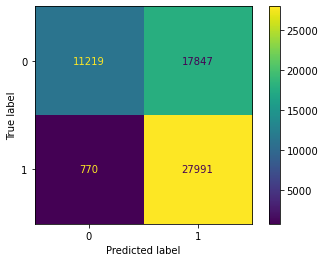

              precision    recall  f1-score   support

           0       0.94      0.39      0.55     29066
           1       0.61      0.97      0.75     28761

    accuracy                           0.68     57827
   macro avg       0.77      0.68      0.65     57827
weighted avg       0.77      0.68      0.65     57827


################################################################################
                Modelo LinearSV com cutoff = 0.15000000000000002                
################################################################################

Métricas de avaliação de teste


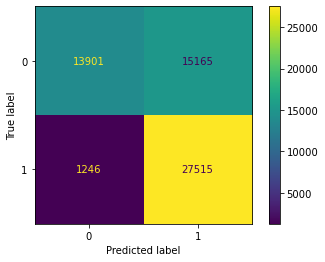

              precision    recall  f1-score   support

           0       0.92      0.48      0.63     29066
           1       0.64      0.96      0.77     28761

    accuracy                           0.72     57827
   macro avg       0.78      0.72      0.70     57827
weighted avg       0.78      0.72      0.70     57827


################################################################################
                Modelo LinearSV com cutoff = 0.20000000000000004                
################################################################################

Métricas de avaliação de teste


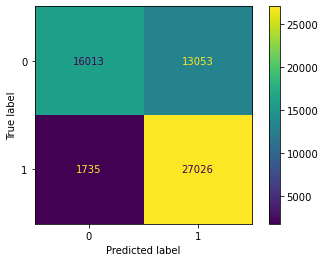

              precision    recall  f1-score   support

           0       0.90      0.55      0.68     29066
           1       0.67      0.94      0.79     28761

    accuracy                           0.74     57827
   macro avg       0.79      0.75      0.73     57827
weighted avg       0.79      0.74      0.73     57827


################################################################################
                Modelo LinearSV com cutoff = 0.25000000000000006                
################################################################################

Métricas de avaliação de teste


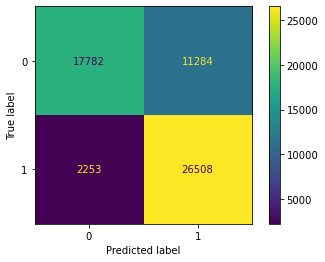

              precision    recall  f1-score   support

           0       0.89      0.61      0.72     29066
           1       0.70      0.92      0.80     28761

    accuracy                           0.77     57827
   macro avg       0.79      0.77      0.76     57827
weighted avg       0.79      0.77      0.76     57827


################################################################################
                Modelo LinearSV com cutoff = 0.30000000000000004                
################################################################################

Métricas de avaliação de teste


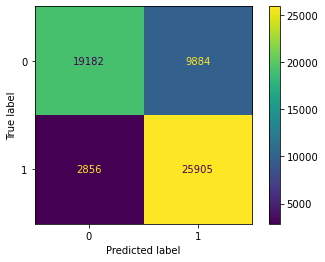

              precision    recall  f1-score   support

           0       0.87      0.66      0.75     29066
           1       0.72      0.90      0.80     28761

    accuracy                           0.78     57827
   macro avg       0.80      0.78      0.78     57827
weighted avg       0.80      0.78      0.78     57827


################################################################################
                Modelo LinearSV com cutoff = 0.3500000000000001                 
################################################################################

Métricas de avaliação de teste


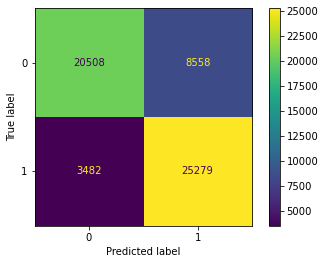

              precision    recall  f1-score   support

           0       0.85      0.71      0.77     29066
           1       0.75      0.88      0.81     28761

    accuracy                           0.79     57827
   macro avg       0.80      0.79      0.79     57827
weighted avg       0.80      0.79      0.79     57827


################################################################################
                Modelo LinearSV com cutoff = 0.40000000000000013                
################################################################################

Métricas de avaliação de teste


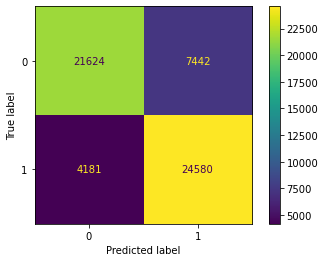

              precision    recall  f1-score   support

           0       0.84      0.74      0.79     29066
           1       0.77      0.85      0.81     28761

    accuracy                           0.80     57827
   macro avg       0.80      0.80      0.80     57827
weighted avg       0.80      0.80      0.80     57827


################################################################################
                Modelo LinearSV com cutoff = 0.45000000000000007                
################################################################################

Métricas de avaliação de teste


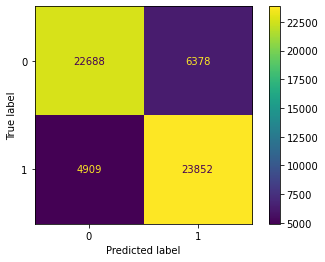

              precision    recall  f1-score   support

           0       0.82      0.78      0.80     29066
           1       0.79      0.83      0.81     28761

    accuracy                           0.80     57827
   macro avg       0.81      0.80      0.80     57827
weighted avg       0.81      0.80      0.80     57827


################################################################################
                Modelo LinearSV com cutoff = 0.5000000000000001                 
################################################################################

Métricas de avaliação de teste


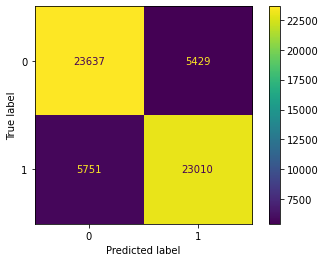

              precision    recall  f1-score   support

           0       0.80      0.81      0.81     29066
           1       0.81      0.80      0.80     28761

    accuracy                           0.81     57827
   macro avg       0.81      0.81      0.81     57827
weighted avg       0.81      0.81      0.81     57827


################################################################################
                Modelo LinearSV com cutoff = 0.5500000000000002                 
################################################################################

Métricas de avaliação de teste


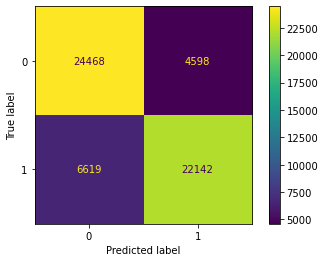

              precision    recall  f1-score   support

           0       0.79      0.84      0.81     29066
           1       0.83      0.77      0.80     28761

    accuracy                           0.81     57827
   macro avg       0.81      0.81      0.81     57827
weighted avg       0.81      0.81      0.81     57827


################################################################################
                Modelo LinearSV com cutoff = 0.6000000000000002                 
################################################################################

Métricas de avaliação de teste


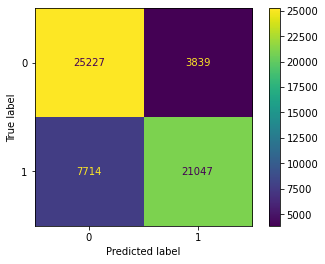

              precision    recall  f1-score   support

           0       0.77      0.87      0.81     29066
           1       0.85      0.73      0.78     28761

    accuracy                           0.80     57827
   macro avg       0.81      0.80      0.80     57827
weighted avg       0.81      0.80      0.80     57827


################################################################################
                Modelo LinearSV com cutoff = 0.6500000000000001                 
################################################################################

Métricas de avaliação de teste


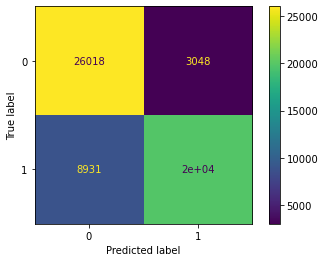

              precision    recall  f1-score   support

           0       0.74      0.90      0.81     29066
           1       0.87      0.69      0.77     28761

    accuracy                           0.79     57827
   macro avg       0.81      0.79      0.79     57827
weighted avg       0.81      0.79      0.79     57827


################################################################################
                Modelo LinearSV com cutoff = 0.7000000000000002                 
################################################################################

Métricas de avaliação de teste


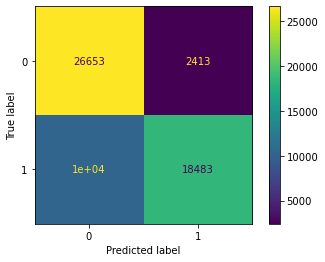

              precision    recall  f1-score   support

           0       0.72      0.92      0.81     29066
           1       0.88      0.64      0.74     28761

    accuracy                           0.78     57827
   macro avg       0.80      0.78      0.78     57827
weighted avg       0.80      0.78      0.78     57827


################################################################################
                Modelo LinearSV com cutoff = 0.7500000000000002                 
################################################################################

Métricas de avaliação de teste


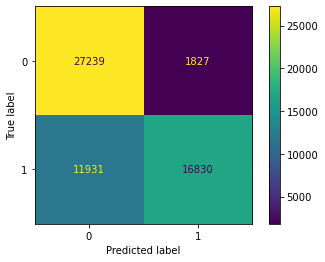

              precision    recall  f1-score   support

           0       0.70      0.94      0.80     29066
           1       0.90      0.59      0.71     28761

    accuracy                           0.76     57827
   macro avg       0.80      0.76      0.75     57827
weighted avg       0.80      0.76      0.75     57827


################################################################################
                Modelo LinearSV com cutoff = 0.8000000000000002                 
################################################################################

Métricas de avaliação de teste


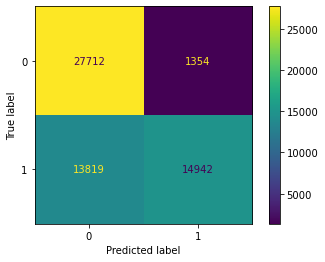

              precision    recall  f1-score   support

           0       0.67      0.95      0.79     29066
           1       0.92      0.52      0.66     28761

    accuracy                           0.74     57827
   macro avg       0.79      0.74      0.72     57827
weighted avg       0.79      0.74      0.72     57827


################################################################################
                Modelo LinearSV com cutoff = 0.8500000000000002                 
################################################################################

Métricas de avaliação de teste


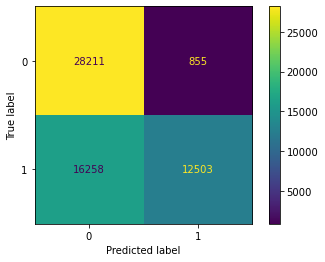

              precision    recall  f1-score   support

           0       0.63      0.97      0.77     29066
           1       0.94      0.43      0.59     28761

    accuracy                           0.70     57827
   macro avg       0.79      0.70      0.68     57827
weighted avg       0.78      0.70      0.68     57827


################################################################################
                Modelo LinearSV com cutoff = 0.9000000000000002                 
################################################################################

Métricas de avaliação de teste


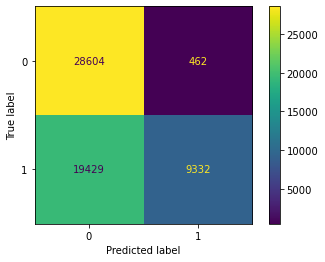

              precision    recall  f1-score   support

           0       0.60      0.98      0.74     29066
           1       0.95      0.32      0.48     28761

    accuracy                           0.66     57827
   macro avg       0.77      0.65      0.61     57827
weighted avg       0.77      0.66      0.61     57827


################################################################################
                Modelo LinearSV com cutoff = 0.9500000000000003                 
################################################################################

Métricas de avaliação de teste


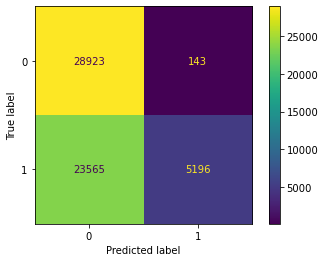

              precision    recall  f1-score   support

           0       0.55      1.00      0.71     29066
           1       0.97      0.18      0.30     28761

    accuracy                           0.59     57827
   macro avg       0.76      0.59      0.51     57827
weighted avg       0.76      0.59      0.51     57827



In [87]:
df_results_train = pd.DataFrame()
df_results_test = pd.DataFrame()

cutoff_list = np.arange(0.1, 1, 0.05)

for cutoff in cutoff_list:
    
    print()
    print("#"*80)
    print(f"Modelo LinearSV com cutoff = {cutoff}".center(80))
    print("#"*80)
    print()
    
    # ============================================
    
    cr_train = clf_metrics(model4, X_train_tf, Y_train, label_metrica="treino", cutoff=cutoff, print_plot=False)
    df_cr_train = pd.DataFrame(cr_train)

    # o .iloc[:-1, :] é pra excluir o "support" (pode trazer tb caso queira)
    df_melt = df_cr_train.iloc[:-1, :].reset_index(drop=False).melt(id_vars='index', var_name="type")
    df_melt['cutoff'] = cutoff

    # corrigindo os dados de acurácia
    accuracy = df_melt.query("type == 'accuracy'").copy()
    accuracy["index"] = "accuracy"

    df_melt = df_melt.drop(index=accuracy.index)
    df_melt = pd.concat([df_melt, accuracy.iloc[[0], :]]).reset_index(drop=False)

    # pivotando
    df_pivot = df_melt.pivot(columns=['type', 'index'], values='value', index='cutoff')
    
    df_results_train = pd.concat([df_results_train, df_pivot])
            
    # ============================================
    
    cr_test = clf_metrics(model4, X_test_tf, Y_test, label_metrica="teste", cutoff=cutoff)
    df_cr_test = pd.DataFrame(cr_test)
    
    # o .iloc[:-1, :] é pra excluir o "support" (pode trazer tb caso queira)
    df_melt = df_cr_test.iloc[:-1, :].reset_index(drop=False).melt(id_vars='index', var_name="type")
    df_melt['cutoff'] = cutoff

    # corrigindo os dados de acurácia
    accuracy = df_melt.query("type == 'accuracy'").copy()
    accuracy["index"] = "accuracy"

    df_melt = df_melt.drop(index=accuracy.index)
    df_melt = pd.concat([df_melt, accuracy.iloc[[0], :]]).reset_index(drop=False)

    # pivotando
    df_pivot = df_melt.pivot(columns=['type', 'index'], values='value', index='cutoff')
    
    df_results_test = pd.concat([df_results_test, df_pivot])
    
    # ============================================

In [88]:
f1 = [row[2] for row in df_results_test['weighted avg'].values ]

In [89]:
f1

[0.6479493443642215,
 0.6991797022647683,
 0.7343807686114421,
 0.7602599283603612,
 0.776532085207541,
 0.790274551010462,
 0.7984230035368284,
 0.8047145125462055,
 0.8066530326741879,
 0.805751740687059,
 0.7992416273797762,
 0.7905663470550356,
 0.776231945631677,
 0.7543500607736885,
 0.7244835929276031,
 0.6809476127767496,
 0.6137275273044142,
 0.5080906799802801]

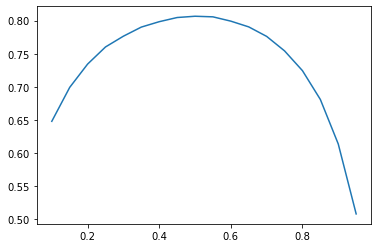

In [91]:
sns.lineplot(y=f1, x=cutoff_list, markers=True, dashes=False);

## Hyperparameter Tuning with Randomized Search

In [95]:
training_pipeline = Pipeline(
    steps=[('tfidf', TfidfVectorizer()), 
           ('model',LinearSVC(random_state=42, tol=1e-5))])

grid_param = [{
    'tfidf__stop_words' : [None, 'english'],
    'tfidf__min_df': [5, 10],
    'tfidf__ngram_range': [(1, 3), (1, 6)],
    'model__penalty': ['l2'],
    'model__loss': ['hinge'],
    'model__max_iter': [10000]
}, {
    
    'tfidf__min_df': [.1, .3],
    'tfidf__ngram_range': [(1, 3), (1, 6)],
    'model__C': [.01, .1],
    'model__tol': [1e-2, 1e-3]
}]

randomizeSearchProcessor =  RandomizedSearchCV(estimator=training_pipeline,
                                   param_distributions=grid_param,
                                   cv=3, scoring='roc_auc')
randomizeSearchProcessor.fit(X_train,Y_train)

best_params = randomizeSearchProcessor.best_params_
print("Best alpha parameter identified by grid search ", best_params)

best_result = randomizeSearchProcessor.best_score_
print("Best result identified by grid search ", best_result)

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best alpha parameter identified by grid search  {'tfidf__stop_words': None, 'tfidf__ngram_range': (1, 3), 'tfidf__min_df': 5, 'model__penalty': 'l2', 'model__max_iter': 10000, 'model__loss': 'hinge'}
Best result identified by grid search  0.8781974350143665


In [108]:
#joblib.dump(randomizeSearchProcessor, 'randomizeSearchProcessor.pkl.xz')

['randomizeSearchProcessor.pkl.xz']

In [107]:
best_model = randomizeSearchProcessor.best_estimator_

In [105]:
model5 = CalibratedClassifierCV(best_model)
model5.fit(X_train, Y_train)
Y_pred = model5.predict(X_test)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Accuracy Score -  0.8101924706452004
              precision    recall  f1-score   support

           0       0.82      0.80      0.81     29066
           1       0.80      0.82      0.81     28761

    accuracy                           0.81     57827
   macro avg       0.81      0.81      0.81     57827
weighted avg       0.81      0.81      0.81     57827




################################################################################
                        Modelo LinearSV com cutoff = 0.1                        
################################################################################

Métricas de avaliação de teste


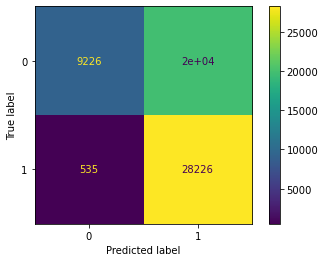

              precision    recall  f1-score   support

           0       0.95      0.32      0.48     29066
           1       0.59      0.98      0.73     28761

    accuracy                           0.65     57827
   macro avg       0.77      0.65      0.61     57827
weighted avg       0.77      0.65      0.60     57827


################################################################################
                Modelo LinearSV com cutoff = 0.15000000000000002                
################################################################################

Métricas de avaliação de teste


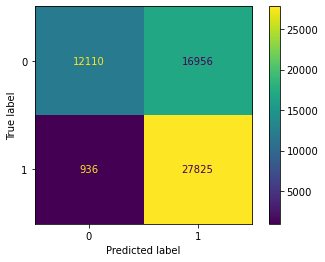

              precision    recall  f1-score   support

           0       0.93      0.42      0.58     29066
           1       0.62      0.97      0.76     28761

    accuracy                           0.69     57827
   macro avg       0.77      0.69      0.67     57827
weighted avg       0.78      0.69      0.67     57827


################################################################################
                Modelo LinearSV com cutoff = 0.20000000000000004                
################################################################################

Métricas de avaliação de teste


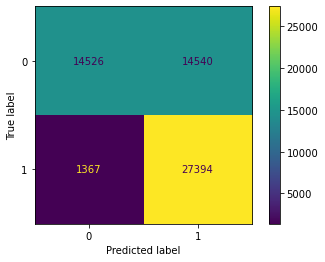

              precision    recall  f1-score   support

           0       0.91      0.50      0.65     29066
           1       0.65      0.95      0.77     28761

    accuracy                           0.72     57827
   macro avg       0.78      0.73      0.71     57827
weighted avg       0.78      0.72      0.71     57827


################################################################################
                Modelo LinearSV com cutoff = 0.25000000000000006                
################################################################################

Métricas de avaliação de teste


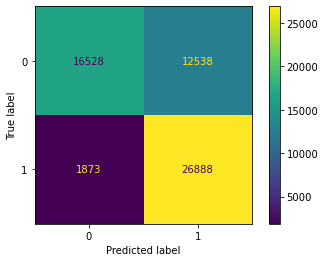

              precision    recall  f1-score   support

           0       0.90      0.57      0.70     29066
           1       0.68      0.93      0.79     28761

    accuracy                           0.75     57827
   macro avg       0.79      0.75      0.74     57827
weighted avg       0.79      0.75      0.74     57827


################################################################################
                Modelo LinearSV com cutoff = 0.30000000000000004                
################################################################################

Métricas de avaliação de teste


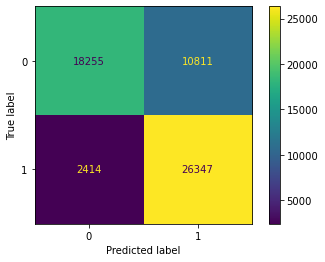

              precision    recall  f1-score   support

           0       0.88      0.63      0.73     29066
           1       0.71      0.92      0.80     28761

    accuracy                           0.77     57827
   macro avg       0.80      0.77      0.77     57827
weighted avg       0.80      0.77      0.77     57827


################################################################################
                Modelo LinearSV com cutoff = 0.3500000000000001                 
################################################################################

Métricas de avaliação de teste


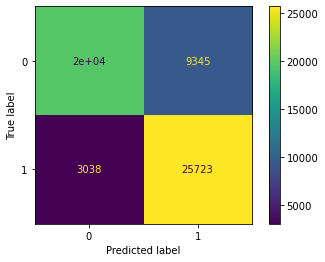

              precision    recall  f1-score   support

           0       0.87      0.68      0.76     29066
           1       0.73      0.89      0.81     28761

    accuracy                           0.79     57827
   macro avg       0.80      0.79      0.78     57827
weighted avg       0.80      0.79      0.78     57827


################################################################################
                Modelo LinearSV com cutoff = 0.40000000000000013                
################################################################################

Métricas de avaliação de teste


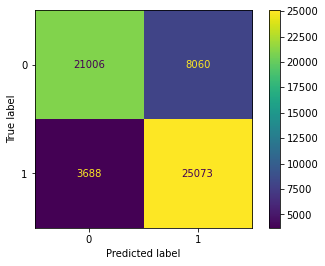

              precision    recall  f1-score   support

           0       0.85      0.72      0.78     29066
           1       0.76      0.87      0.81     28761

    accuracy                           0.80     57827
   macro avg       0.80      0.80      0.80     57827
weighted avg       0.80      0.80      0.80     57827


################################################################################
                Modelo LinearSV com cutoff = 0.45000000000000007                
################################################################################

Métricas de avaliação de teste


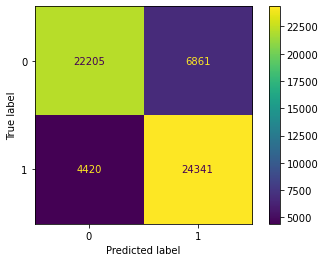

              precision    recall  f1-score   support

           0       0.83      0.76      0.80     29066
           1       0.78      0.85      0.81     28761

    accuracy                           0.80     57827
   macro avg       0.81      0.81      0.80     57827
weighted avg       0.81      0.80      0.80     57827


################################################################################
                Modelo LinearSV com cutoff = 0.5000000000000001                 
################################################################################

Métricas de avaliação de teste


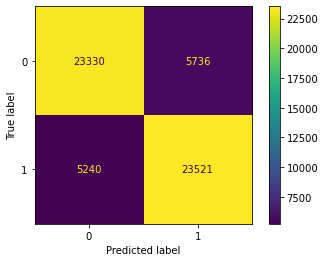

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     29066
           1       0.80      0.82      0.81     28761

    accuracy                           0.81     57827
   macro avg       0.81      0.81      0.81     57827
weighted avg       0.81      0.81      0.81     57827


################################################################################
                Modelo LinearSV com cutoff = 0.5500000000000002                 
################################################################################

Métricas de avaliação de teste


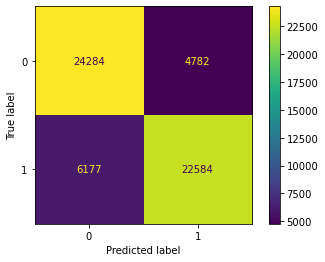

              precision    recall  f1-score   support

           0       0.80      0.84      0.82     29066
           1       0.83      0.79      0.80     28761

    accuracy                           0.81     57827
   macro avg       0.81      0.81      0.81     57827
weighted avg       0.81      0.81      0.81     57827


################################################################################
                Modelo LinearSV com cutoff = 0.6000000000000002                 
################################################################################

Métricas de avaliação de teste


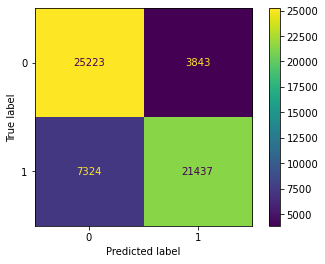

              precision    recall  f1-score   support

           0       0.77      0.87      0.82     29066
           1       0.85      0.75      0.79     28761

    accuracy                           0.81     57827
   macro avg       0.81      0.81      0.81     57827
weighted avg       0.81      0.81      0.81     57827


################################################################################
                Modelo LinearSV com cutoff = 0.6500000000000001                 
################################################################################

Métricas de avaliação de teste


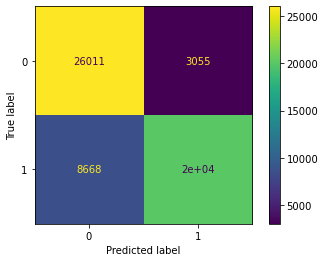

              precision    recall  f1-score   support

           0       0.75      0.89      0.82     29066
           1       0.87      0.70      0.77     28761

    accuracy                           0.80     57827
   macro avg       0.81      0.80      0.80     57827
weighted avg       0.81      0.80      0.80     57827


################################################################################
                Modelo LinearSV com cutoff = 0.7000000000000002                 
################################################################################

Métricas de avaliação de teste


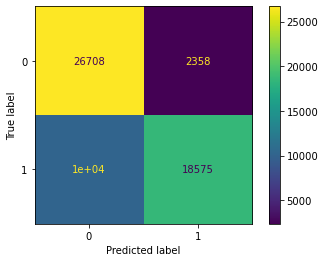

              precision    recall  f1-score   support

           0       0.72      0.92      0.81     29066
           1       0.89      0.65      0.75     28761

    accuracy                           0.78     57827
   macro avg       0.81      0.78      0.78     57827
weighted avg       0.81      0.78      0.78     57827


################################################################################
                Modelo LinearSV com cutoff = 0.7500000000000002                 
################################################################################

Métricas de avaliação de teste


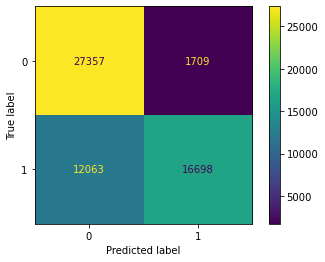

              precision    recall  f1-score   support

           0       0.69      0.94      0.80     29066
           1       0.91      0.58      0.71     28761

    accuracy                           0.76     57827
   macro avg       0.80      0.76      0.75     57827
weighted avg       0.80      0.76      0.75     57827


################################################################################
                Modelo LinearSV com cutoff = 0.8000000000000002                 
################################################################################

Métricas de avaliação de teste


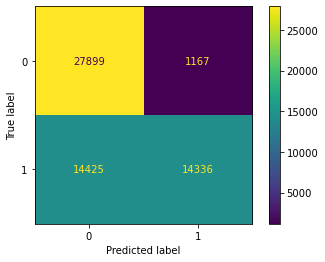

              precision    recall  f1-score   support

           0       0.66      0.96      0.78     29066
           1       0.92      0.50      0.65     28761

    accuracy                           0.73     57827
   macro avg       0.79      0.73      0.71     57827
weighted avg       0.79      0.73      0.72     57827


################################################################################
                Modelo LinearSV com cutoff = 0.8500000000000002                 
################################################################################

Métricas de avaliação de teste


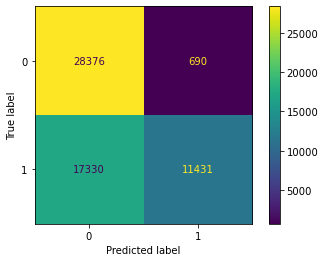

              precision    recall  f1-score   support

           0       0.62      0.98      0.76     29066
           1       0.94      0.40      0.56     28761

    accuracy                           0.69     57827
   macro avg       0.78      0.69      0.66     57827
weighted avg       0.78      0.69      0.66     57827


################################################################################
                Modelo LinearSV com cutoff = 0.9000000000000002                 
################################################################################

Métricas de avaliação de teste


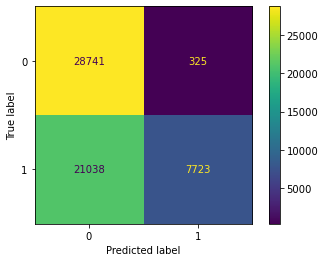

              precision    recall  f1-score   support

           0       0.58      0.99      0.73     29066
           1       0.96      0.27      0.42     28761

    accuracy                           0.63     57827
   macro avg       0.77      0.63      0.57     57827
weighted avg       0.77      0.63      0.58     57827


################################################################################
                Modelo LinearSV com cutoff = 0.9500000000000003                 
################################################################################

Métricas de avaliação de teste


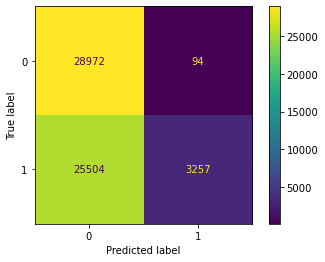

              precision    recall  f1-score   support

           0       0.53      1.00      0.69     29066
           1       0.97      0.11      0.20     28761

    accuracy                           0.56     57827
   macro avg       0.75      0.56      0.45     57827
weighted avg       0.75      0.56      0.45     57827



In [106]:
for cutoff in cutoff_list:
    
    print()
    print("#"*80)
    print(f"Modelo LinearSV com cutoff = {cutoff}".center(80))
    print("#"*80)
    print()
    
    # ============================================
    
    cr_train = clf_metrics(model5, X_train, Y_train, label_metrica="treino", cutoff=cutoff, print_plot=False)
    df_cr_train = pd.DataFrame(cr_train)

    # o .iloc[:-1, :] é pra excluir o "support" (pode trazer tb caso queira)
    df_melt = df_cr_train.iloc[:-1, :].reset_index(drop=False).melt(id_vars='index', var_name="type")
    df_melt['cutoff'] = cutoff

    # corrigindo os dados de acurácia
    accuracy = df_melt.query("type == 'accuracy'").copy()
    accuracy["index"] = "accuracy"

    df_melt = df_melt.drop(index=accuracy.index)
    df_melt = pd.concat([df_melt, accuracy.iloc[[0], :]]).reset_index(drop=False)

    # pivotando
    df_pivot = df_melt.pivot(columns=['type', 'index'], values='value', index='cutoff')
    
    df_results_train = pd.concat([df_results_train, df_pivot])
            
    # ============================================
    
    cr_test = clf_metrics(model5, X_test, Y_test, label_metrica="teste", cutoff=cutoff)
    df_cr_test = pd.DataFrame(cr_test)
    
    # o .iloc[:-1, :] é pra excluir o "support" (pode trazer tb caso queira)
    df_melt = df_cr_test.iloc[:-1, :].reset_index(drop=False).melt(id_vars='index', var_name="type")
    df_melt['cutoff'] = cutoff

    # corrigindo os dados de acurácia
    accuracy = df_melt.query("type == 'accuracy'").copy()
    accuracy["index"] = "accuracy"

    df_melt = df_melt.drop(index=accuracy.index)
    df_melt = pd.concat([df_melt, accuracy.iloc[[0], :]]).reset_index(drop=False)

    # pivotando
    df_pivot = df_melt.pivot(columns=['type', 'index'], values='value', index='cutoff')
    
    df_results_test = pd.concat([df_results_test, df_pivot])
    
    # ============================================

In [110]:
randomizesearch_results = pd.DataFrame(randomizeSearchProcessor.cv_results_)
randomizesearch_results[['rank_test_score', 'mean_test_score',
                    'params']].sort_values(by=['rank_test_score'])[:5]

rank_test_score  mean_test_score  \
1                1         0.878197   
2                2         0.844051   
6                3         0.616182   
7                3         0.616182   
0                5         0.616140   

                                              params  
1  {'tfidf__stop_words': None, 'tfidf__ngram_rang...  
2  {'tfidf__stop_words': 'english', 'tfidf__ngram...  
6  {'tfidf__ngram_range': (1, 6), 'tfidf__min_df'...  
7  {'tfidf__ngram_range': (1, 3), 'tfidf__min_df'...  
0  {'tfidf__ngram_range': (1, 3), 'tfidf__min_df'...

In [96]:
best_model = randomizeSearchProcessor.best_estimator_
Y_pred = best_model.predict(X_test)

## Explain Text Classifier

In [111]:
## Create a dataframe combining the Title and Description, 
## Actual and Predicted values that we can explore
frame = { 'text': X_test, 'actual': Y_test, 'predicted': Y_pred } 
result = pd.DataFrame(frame)

In [112]:
result[result['actual'] == result['predicted']].sample(12, random_state=21)

text  actual  predicted
206968   USER another one of my all time faves on cons...       1          1
251694     USER hehehe sowwy you are entertaining though        1          1
215496   USER welcome thought i d do it now before you...       1          1
116799   USER URL you look gorg in this pic uncanny ho...       1          1
286221                                        USER oh kl        1          1
115046   USER the unemployment was horrendous apparent...       0          0
172082   USER for sures will totally watch jonas tonig...       1          1
252759  off to get some zz couldn t ask for a better b...       1          1
275760                     is watching grey s anatomy URL       1          1
2983    cooking stir fryy and watching 27 dresses wait...       1          1
40607   doing a lot of ass kissing to teachers today i...       1          1
148596   USER ur gonna delete ur account afterwards oo...       0          0

In [113]:
result[result['actual'] != result['predicted']].sample(12, random_state=42)

text  actual  predicted
191889  n yes i would call those people a fucktard to ...       1          0
50440   reading some more of shutter island then off t...       0          1
79672                     USER that s really depressingg        0          1
206419   USER that sucks well don t let them get you d...       1          0
116680   USER thats good to hear do we have doug back ...       0          1
30052    haveyouever kissed in the rain while streaks ...       1          0
46375    USER i heard over on twitter that drag me to ...       1          0
187895          is revising for his last few exams whoop        1          0
75930   have been to portugal and spain and has a sore...       1          0
200897  i love the super nice weather now i must pick ...       0          1
237028   USER aww i think we should go and get some ph...       0          1
98661    USER aww your super shy no way get out of her...       0          1

In [114]:
text = result.iloc[21]["text"]
print(text)

 USER a chance to claim expenses for lightbulb changing 


In [116]:
model4.predict_proba(X_test_tf[21])

array([[0.1985256, 0.8014744]])

In [119]:
class_names = ["0", "1"]
prob = model4.predict_proba(X_test_tf)
# new dataframe for explainable results
er = result.copy().reset_index()
for i, c in enumerate(class_names):
    er[c] = prob[:, i]

In [120]:
er[["actual", "predicted"] + class_names].sample(5, random_state=99)

actual  predicted         0         1
51673       1          1  0.145427  0.854573
7721        1          1  0.053703  0.946297
46722       1          0  0.943050  0.056950
33857       1          1  0.004401  0.995599
12158       1          1  0.272789  0.727211

In [121]:
er['max_probability'] = er[class_names].max(axis=1)
correct = (er[er['actual'] == er['predicted']])
wrong   = (er[er['actual'] != er['predicted']])

In [128]:
er.head()

index                                               text  actual  \
0   43038             watching guitar hero vid s on youtube        1   
1  203122  happy mother s day to all you mommas we spent ...       1   
2   50761  this sunday is so ssllooww gorgeous day and im...       0   
3   10171            wendy plleeaasse write my essay for me        1   
4  146531   is having a quite night in with david and maddy        1   

   predicted         0         1  max_probability  
0          1  0.085296  0.914704         0.914704  
1          1  0.068226  0.931774         0.931774  
2          0  0.831227  0.168773         0.831227  
3          0  0.550458  0.449542         0.550458  
4          1  0.086703  0.913297         0.913297

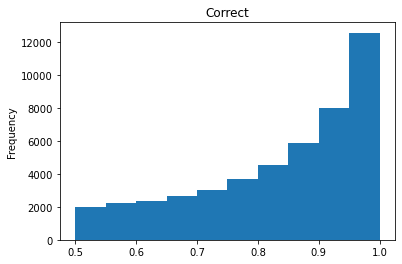

In [122]:
import matplotlib.pyplot as plt
correct["max_probability"].plot.hist(title="Correct")
plt.savefig("correct.svg")

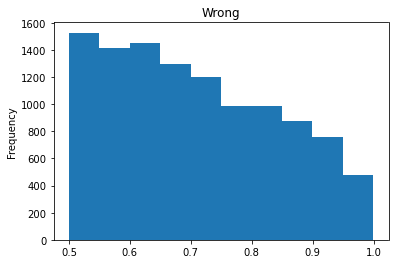

In [123]:
wrong["max_probability"].plot.hist(title="Wrong")
plt.savefig("wrong.svg")

In [124]:
len(correct), len(wrong)

(46851, 10976)

In [126]:
high = er[er["max_probability"] > 0.8]
len(high)

34044

In [129]:
print(classification_report(high["actual"], high["predicted"]))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     17367
           1       0.92      0.90      0.91     16677

    accuracy                           0.91     34044
   macro avg       0.91      0.91      0.91     34044
weighted avg       0.91      0.91      0.91     34044



In [130]:
print(classification_report(er["actual"], er["predicted"]))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     29066
           1       0.80      0.82      0.81     28761

    accuracy                           0.81     57827
   macro avg       0.81      0.81      0.81     57827
weighted avg       0.81      0.81      0.81     57827



In [142]:
best_model['model'].coef_

array([[ 0.46528778,  0.50187163, -0.5402318 , ...,  0.24697475,
         0.56008584,  0.41220295]])

In [145]:
# coef_[1] yields a matrix, A[0] converts to array and takes first row
coef = best_model['model'].coef_[0]
vocabulary_positions = coef.argsort()
vocabulary = tfidf.get_feature_names_out()

In [146]:
top_words = 10
top_positive_coef = vocabulary_positions[-top_words:].tolist()
top_negative_coef = vocabulary_positions[:top_words].tolist()

In [147]:
core_ui = pd.DataFrame([[vocabulary[c], coef[c]] for c in top_positive_coef + top_negative_coef], 
                          columns=["feature", "coefficient"]).sort_values("coefficient")

In [148]:
core_ui.set_index("feature")

coefficient
feature                        
awards freaks        -10.742122
api limits            -8.295306
app me                -6.809009
ate lunch             -6.537113
awareness with        -6.511724
bacon user            -6.129925
benadryl vet          -6.100030
blunt by              -5.991938
ayt                   -5.729164
app again             -5.700050
alishaa                3.754777
baby haven             3.859929
already tweet          3.926938
aargghh                3.964657
adminaddict scared     4.122583
all must               4.136857
around los             4.147240
barbecue was           4.707726
abaigail               4.889563
arriana killed         5.156081

## LIME

In [157]:
model5.predict_proba(
    ["I haven't seen it and I don't like it ... anyway I was joking I saw it and it's a great movie!!!"])


array([[0.59204199, 0.40795801]])

In [158]:
class_names

['0', '1']

In [159]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

In [160]:
er[er["predicted"] != er["actual"]].head(5)

index                                               text  actual  \
3    10171            wendy plleeaasse write my essay for me        1   
8   284537   USER that sounds like a plan i am so unbeliev...       0   
16  197993  jennifer good monday morning everyone hope you...       0   
33   27845  off to sub in clinton hope they actually need ...       1   
40  172811  reaching for my protein bar yet the yummy food...       0   

    predicted         0         1  max_probability  
3           0  0.550458  0.449542         0.550458  
8           1  0.567439  0.432561         0.567439  
16          1  0.314089  0.685911         0.685911  
33          0  0.715639  0.284361         0.715639  
40          1  0.171283  0.828717         0.828717

In [163]:
er.iloc[21][1]

' USER a chance to claim expenses for lightbulb changing '

In [212]:
id = 99
print('Document id: %d' % id)
print('Predicted class =', er.iloc[id]["predicted"])
print('True class: %s' % er.iloc[id]["actual"])

Document id: 99
Predicted class = 1
True class: 1


In [213]:
exp = explainer.explain_instance(result.iloc[id]["text"], model5.predict_proba, num_features=10, labels=[0, 1])
#print('Explanation for class %s' % class_names[0])
#print('\n'.join(map(str, exp.as_list(label=0))))
print()
print('Explanation for class %s' % class_names[1])
print('\n'.join(map(str, exp.as_list(label=1))))


Explanation for class 1
('smiled', 0.10563198378064048)
('cutie', 0.09599626291964321)
('only', -0.09597781122054976)
('was', -0.08883017026934854)
('time', 0.07927703426373993)
('USER', 0.07117488712842107)
('gas', -0.06742940703493977)
('son', 0.06732325353019994)
('passing', -0.03800943997362717)
('are', -0.03402315073609574)


In [216]:
exp = explainer.explain_instance(result.iloc[id]["text"], model5.predict_proba, num_features=20, top_labels=None)
print(exp.available_labels())

[1]


In [217]:
exp.show_in_notebook(text=False)

In [172]:
from lime import submodular_pick

In [193]:
import numpy as np
np.random.seed(42)
lsm = submodular_pick.SubmodularPick(explainer, er["text"].values[:100], model5.predict_proba, 
                                        method='full',
                                        num_features=20,
                                        num_exps_desired=5)

In [202]:
id = 99
print('Document id: %d' % id)
print('Predicted class =', er.iloc[id]["predicted"])
print('True class: %s' % er.iloc[id]["actual"])

Document id: 99
Predicted class = 1
True class: 1


In [218]:
er["text"].values[99]

' USER babies are so precious he s a cutie the only time my son smiled in his sleep was when he was passing gas '

In [201]:
lsm.explanations[99].show_in_notebook()